    Pergunta 5- prevalência de fumantes entre os contaminados influênciam na taxa de mortalidade 

In [1]:
#!pip install plotly

In [2]:
from controller import *
import math
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

In [3]:
columns = ['continent','location','new_cases','new_deaths', 'new_tests', 'male_smokers', 'female_smokers','population']
df = load_df(columns)
df['smokers'] = df['male_smokers'] + df['female_smokers']

# n_days = True
# df_ARG, df_BOL, df_BRA, df_CHI, df_COL, df_ECU, df_FIS, df_GUY, df_PAR, df_PER, df_SUR, df_URU, df_VEN = comum_preprocess(df, n_days)

In [4]:
df_completo = pd.read_csv('../data/owid-covid-data.csv')

#rate of smokers per total of deaths in the world
df_completo['smokers'] = df_completo['male_smokers'] + df_completo['female_smokers']
rate = df_completo['smokers'].sum()/df_completo['new_deaths'].sum()

# cases = int(df_completo['new_cases'].sum())
# print('Em uma amostra total de {} casos, a razão nmr de fumantes por morte é {}%'.format(cases, round(100*rate,2)))
# rate_B = df_BRA['smokers'].sum()/df_BRA['new_deaths'].sum()
# casesB = int(df_BRA['new_cases'].sum())
# print('BRA, total cases ', casesB, 'taxa fumante por morte ', round(100*rate_B,2),'%')

# Análise Exploratória

In [5]:
#defining inhabitants nmr 
df2 = load_df(['continent','location', 'population'])
df2 = df2.drop(['continent'], axis = 1)
df2 = df2.groupby(['location']).mean()

df1 = df.groupby(['location']).sum()

df1['population'] = df2
df1['smoker_rate'] = df1['smokers']/df1['population']*1000
df1

,new_cases,new_deaths,new_tests,male_smokers,female_smokers,population,smokers,smoker_rate
location,,,,,,,,
Argentina,790805.0,20795.0,1679290.0,6564.9,3839.4,45195777.0,10404.3,0.230205
Bolivia,136569.0,8073.0,294576.0,0.0,0.0,11673029.0,0.0,0.000000
Brazil,4906833.0,145987.0,0.0,4994.1,2817.9,212559409.0,7812.0,0.036752
Chile,468471.0,12919.0,3347825.0,8881.0,7318.8,19116209.0,16199.8,0.847438
Colombia,848147.0,26556.0,3276973.0,2889.0,1005.8,50882884.0,3894.8,0.076544
Ecuador,140351.0,11597.0,360162.0,3431.7,558.0,17643060.0,3989.7,0.226134
Falkland Islands,13.0,0.0,0.0,0.0,0.0,3483.0,0.0,0.000000
Guyana,3005.0,85.0,0.0,0.0,0.0,786559.0,0.0,0.000000
Paraguay,43452.0,913.0,269710.0,4579.2,1060.0,7132530.0,5639.2,0.790631


    taxa de mortalidade
    
    Seja uma constante de comparação K de tal forma que taxa de mortalidade = k*taxa de fumantes. Dessa forma, considerando k contante, a definição da função fica relacionada com o a nossa pergunta (Quanto maior a taxa de mortalidade, maior deve ser a taxa de fumantes).

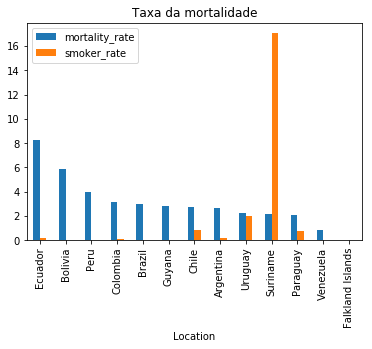

In [6]:
df1['mortality_rate'] = df1['new_deaths']/df1['new_cases']*100
df1 = df1.sort_values(by=['mortality_rate'], ascending=False)
df1.reset_index().plot(x="location", y=["mortality_rate","smoker_rate"], kind="bar",fontsize=10)
plt.title("Taxa da mortalidade")
plt.rcParams['figure.figsize'] = (11,7)
plt.xlabel("Location")
# plt.ylabel("Rate")


plt.show()

    Dado a falta de dados qus os países disponibilizam o nosso data set ficou extremamtente desbalanceado. Mas c-omo estamos tratando de um problema da vida real, vamos dar seguimento e fazer as análises estatisticas pos-síveis.

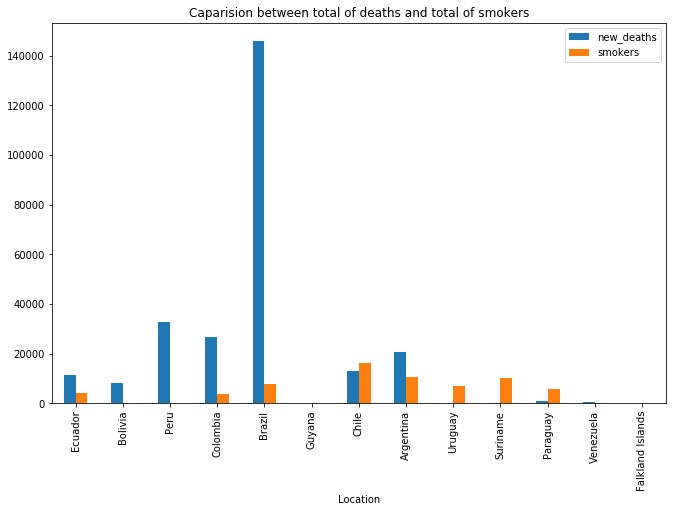

In [7]:
df1.reset_index().plot(x="location", y=["new_deaths", "smokers"], kind="bar",fontsize=10)
plt.title("Caparision between total of deaths and total of smokers")
plt.rcParams['figure.figsize'] = (11,7)
plt.xlabel("Location")
# plt.ylabel("deaths")


plt.show()

In [8]:
#droping continent and NAN values
df = df.drop(['continent'], axis=1)
df = df[df['male_smokers'].notna()]

#normalizing smokers and total o
df_normalized = df
df_normalized['smokers'] = (df['smokers']-df['smokers'].mean())/df['smokers'].std()
df_normalized['new_deaths'] = (df['new_deaths']-df['new_deaths'].mean())/df['new_deaths'].std()


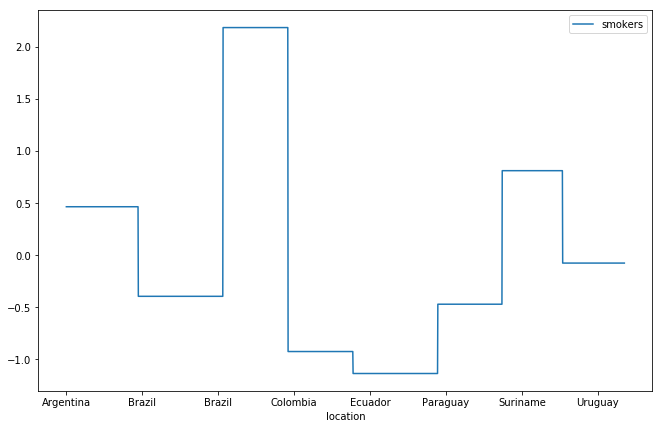

In [9]:
# gca stands for 'get current axis'
ax = plt.gca()

df_normalized.plot(kind='line',x='location',y='smokers',ax=ax)
# df_normalized.plot(kind='line',x='location',y='new_deaths', color='red', ax=ax)
plt.rcParams['figure.figsize'] = (11,7)

plt.show()

# Regressão

    Para realizarmos as análises de regressão, vamos utilizar o data set do mundo inteitro afim de balancear um pouco mais.

In [10]:
df_completo

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,smokers
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498,NaN
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498,NaN
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498,NaN
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498,NaN
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47954,NaN,NaN,International,2020-09-30,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47955,NaN,NaN,International,2020-10-01,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47956,NaN,NaN,International,2020-10-02,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47957,NaN,NaN,International,2020-10-03,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
x = df_completo.dropna()
y = x['smokers']

#droping nominal comlumns
x = x.select_dtypes(include=['float64'])

#normalizing
x=(x-x.mean())/x.std()

#droping vies colums
x = x.drop(columns = ['smokers','male_smokers','female_smokers']) 

#splitting 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [12]:
regr = LinearRegression() # cria o modelo 
regr.fit(X_train, y_train) # treina o modelo

r2_train = regr.score(X_train, y_train)
r2_test = regr.score(X_test, y_test)
print('R2 no set de treino: %.2f' % r2_train)
print('R2 no set de teste: %.2f' % r2_test)

R2 no set de treino: 0.81
R2 no set de teste: 0.82


In [17]:
#cross validation

#create a new model
reg2 = LinearRegression()

#aplying
scores = cross_val_score(reg2, X_train, y_train, cv = 5)

#use cros val to get predict
predictions = cross_val_predict(reg2, X_test, y_test, cv = 5) 

#fit model to data
reg2.fit(X_train, y_train)

y_hat = reg2.predict(X_test)

reg2.score(X_test, y_test)

0.8220391539959818

In [14]:
# Create KNN classifier
knn = KNeighborsRegressor()
# Fit the classifier to the data
knn.fit(X_train,y_train)

r2_train_knn = knn.score(X_train, y_train)
r2_test_knn = knn.score(X_test, y_test)
print('R2 no set de treino: %.2f' % r2_train_knn)
print('R2 no set de teste: %.2f' % r2_test_knn)

R2 no set de treino: 1.00
R2 no set de teste: 1.00


In [15]:
y_prev = regr.predict(X_test)
y_prev_knn = knn.predict(X_test)

Reg Linear plot


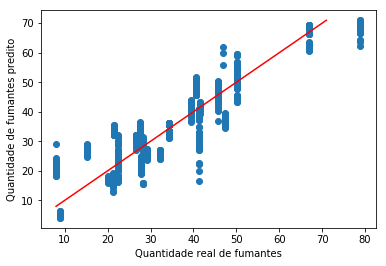

Reg Linear with cv plot


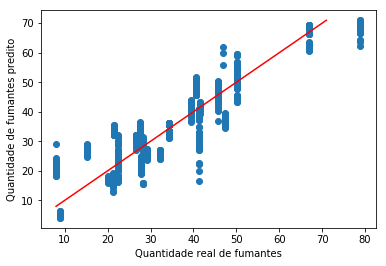

Knn plot


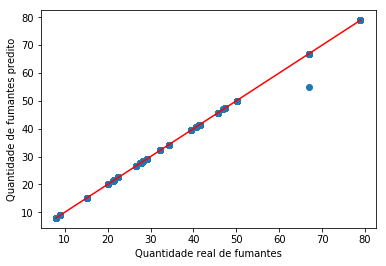

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

print("Reg Linear plot")
plt.scatter(y_test, y_prev)
ranger = [y_test.min(), y_prev.max()]
plt.plot(ranger, ranger, 'red')
plt.xlabel('Quantidade real de fumantes')
plt.ylabel('Quantidade de fumantes predito')
plt.show()

print("Reg Linear with cv plot")
plt.scatter(y_test, y_hat)
ranger = [y_test.min(), y_hat.max()]
plt.plot(ranger, ranger, 'red')
plt.xlabel('Quantidade real de fumantes')
plt.ylabel('Quantidade de fumantes predito')
plt.show()

print('Knn plot')
plt.scatter(y_test, y_prev_knn)
ranger = [y_test.min(), y_prev_knn.max()]
plt.plot(ranger, ranger, 'red')
plt.xlabel('Quantidade real de fumantes')
plt.ylabel('Quantidade de fumantes predito')
plt.show()

In [19]:
print(f'MSE reg lin {mean_squared_error(y_test, y_prev)}')
print(f'MSE knn {mean_squared_error(y_test, y_prev_knn)}')

MSE reg lin 51.48549233037148
MSE knn 0.12424503882657449


# Classificação

    supervised larning to multiclass. In this topic we'll work with the whole data to classify, given the number o smokers and some rates, which country this set of data belongs. In one hand we can classify with location and work with a dasbalanced data and several class. In another hand, just continent is suficient to archive a small number of missclassification. 

In [20]:
df_completo.groupby(['continent']).mean()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,smokers
continent,,,,,,,,,,,,,,,,,,,,,
Africa,10113.792524,136.116287,137.175160,240.725623,3.280607,3.314015,589.704121,7.781089,7.807032,9.738158,...,32.933258,287.778410,5.700622,2.516542,27.425523,26.643491,1.511971,64.409414,0.548640,29.942064
Asia,59415.573125,977.255451,955.906654,1276.492998,17.748803,17.460741,2168.903693,27.254323,26.835739,19.690470,...,5.366726,283.289355,9.474495,4.757509,39.369841,71.715906,2.878598,74.685479,0.732031,44.127349
Europe,37820.496464,422.890934,412.125853,2624.442694,18.075711,18.167889,2917.112410,30.192458,29.327617,131.295096,...,0.932022,223.488644,6.417837,23.400574,34.981486,94.025573,5.175416,79.948043,0.869211,58.382059
North America,99722.789530,1196.070604,1192.788122,4238.697852,41.796242,41.965444,2072.218093,33.761150,33.266514,63.299044,...,5.173202,195.298945,10.807446,7.416255,22.081987,77.263318,2.295832,76.713712,0.752306,29.902293
Oceania,1756.100462,19.603926,19.728165,33.491917,0.570439,0.574407,660.550773,14.905210,13.842437,11.795349,...,0.924432,271.883788,15.113437,14.874627,27.591940,NaN,2.939591,76.566304,0.806015,42.466567
South America,201078.221747,2939.927629,2930.976357,6901.427807,92.829590,92.334350,3818.972791,54.111720,53.706107,123.624618,...,2.883301,184.647377,7.708661,10.682459,23.904570,66.804662,2.082970,75.623679,0.752183,35.291132


In [21]:
x1 = df_completo.dropna()

y1 = x1['continent']
y1 = y1.values

#droping nominal comlumns
# x = x.drop(columns = ['location','iso_code','date','continent'], axis=1) 
x1 = x1.select_dtypes(include=['float64'])

#normalizing
x1 = (x1-x1.mean())/x1.std()

#transform into categorical data 
for i in range (len(y1)):
    if y1[i] == "Africa":
        y1[i] = 0
    if y1[i] == "Asia":
        y1[i] = 1
    if y1[i] == "Europe":
        y1[i] = 2
    if y1[i] == "North America":
        y1[i] = 3
    if y1[i] == "Oceania":
        y1[i] = 4
    if y1[i] == "South America":
        y1[i] = 5
        
y1 = pd.DataFrame(data=y1, columns=["continent"])
y1=y1.astype('int')

data = pd.DataFrame(y1['continent'])
data['smokers_rate'] = x1['smokers'].values/x1['population'].values #taxa de fumantes
data['death_rate'] = x1['total_deaths'].values / x1['total_cases'].values #taxa de mortes
# data['smokers'] = x1['smokers'].values #nmr de fumantes
data = data.drop(columns = ['continent'])
data

,smokers_rate,death_rate
0,5.378220,1.227769
1,5.378220,1.227800
2,5.378220,1.227820
3,5.378220,1.227820
4,5.378220,1.227891
...,...,...
3857,0.319931,1.226136
3858,0.319931,1.226430
3859,0.319931,1.226811
3860,0.319931,1.226986


In [22]:
X_train, X_test, y_train, y_test = train_test_split(data, y1, test_size=0.3, random_state=42)

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)


/home/rudda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [25]:
from sklearn import metrics

In [26]:
class_names=[]
class_names.append("Africa")
class_names.append("Asia")
# class_names.append("Europe")
class_names.append("North America")
# class_names.append("Oceania")
class_names.append("South America")

In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_test, rf.predict(X_test), target_names=class_names))

               precision    recall  f1-score   support

       Africa       1.00      1.00      1.00       488
         Asia       1.00      1.00      1.00       438
North America       1.00      0.99      1.00       168
South America       1.00      1.00      1.00        65

     accuracy                           1.00      1159
    macro avg       1.00      1.00      1.00      1159
 weighted avg       1.00      1.00      1.00      1159



    Feature importance

In [29]:
col_sorted_by_importance=rf.feature_importances_.argsort()
feat_imp=pd.DataFrame({
    'cols':data.columns[col_sorted_by_importance],
    'imps':rf.feature_importances_[col_sorted_by_importance]
})

px.bar(feat_imp, x='cols', y='imps')

# Considerações finais 

       Apesar dos dados se mostrarem extremamente desbalanceado, por causa da baixa padronização de informação disponível, e a pergunta inicial não ser respondida, nesta seção, conseguimos desenvolver muitos modelos estatísticos e podemos, ao longo dessa análise 5, aprender um pouco com os dados disponibilizados.
   
       A estrutura dessa análise 5 consistiu nos seguintes passos:
           1-Análise exploratória dos dados (Logo nesta etapa percebemos que seria complexa a abordagem do problema)
           2-Etapa de regressão levando em consideração dois algorítimos utilizados nas salas de ICD
           3-Etapa de classificação utilizando um algoritmo não abordado em sala mas de relevância, o Random Forest